In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
South_Wake = 'South Wake Landfill, 6300, Old Smithfield Road, Apex, NC, 27539'
North_Wake = 'North Wake Landfill, 9300, Deponie Drive, Raleigh, NC, 27614'

In [3]:
South_Wake_Hazard = 'South Wake Household Hazardous Waste Facility, 6150, Old Smithfield Road, Apex, NC, 27539'
North_Wake_Hazard = 'North Wake Household Hazardous Waste Facility, 9037, Deponie Dr, Raleigh, NC, 27614'
East_Wake_Hazard = 'East Wake Household Hazardous Waste Facility, 5051, Wendell Boulevard, Wendell, NC, 27591'

In [4]:
South_Wake_Material = 'South Wake Multi-Material Recycling Facility, 6130, Old Smithfield Road, Apex, NC, 27539'
North_Wake_Material = 'North Wake Multi-Material Recycling Facility, 9029, Deponie Drive, Raleigh, NC, 27614'
East_Wake_Material = 'East Wake Multi-Material Recycling Facility, 5051, Wendell Boulevard, Wendell, NC, 27591'

In [5]:
Old_Stage_Road = 'Convenience Center Site 1, 10505, Old Stage Road, Raleigh, NC, 27603'
Old_SmithField_Road = 'Convenience Center Site 2, 6120, Old Smithfield Road, Apex, NC, 27539'
Aviation_Parkway = 'Convenience Center Site, 3266, Aviation Parkway, Morrisville, NC, 27560'
Yates_Mill = 'Convenience Center Site 4, 3600, Yates Mill Pond Road, Raleigh, NC, 27606'
Battle_Bridge = 'Convenience Center Site 5, 8401, Battle Bridge Road, Raleigh, NC, 27610'
Lillie_Liles = 'Convenience Center Site 6, 3913, Lillie Liles Road, Wake Forest, NC, 27587'
Deponie_Drive = 'Convenience Center Site 7, 9029, Deponie Drive, Raleigh, NC, 27614'
Durham_Highway = 'Convenience Center Site 8, 2001, Durham Road, Wake Forest, NC, 27587'
New_Hill_Holeman = 'Convenience Center Site 9, 3337, New Hill-Holleman Road, New Hill, NC, 27562'
KnightDale_Eagle_Rock = 'Convenience Center Site 10, 5216, Knightdale-Eagle Rock Road, Knightdale, NC, 27545'
Wendell_Boulevard = 'Convenience Center Site 11, 5051, Wendell Boulevard, Wendell, NC, 27591'

In [6]:
import nltk 
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
def check_location(text):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text))):
        if hasattr(chunk, "label"):
            if chunk.label() == "GPE" or chunk.label() == "GSP":
                return "True"
    return "False"

text="Convenience Center Site 10, 5216, Knightdale-Eagle Rock Road, Knightdale, NC, 27545"
print(check_location(South_Wake))

text="Convenience Center Site 11, 5051, Wendell Boulevard, Wendell, NC, 27591"
print(check_location(text))

text = "Convenience Center Site 9, 3337, New Hill-Holleman Road, New Hill, NC, 27562"
print(check_location(text))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sawag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\sawag\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\sawag\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True
True
True


In [7]:
Adlist = [South_Wake, North_Wake, South_Wake_Hazard, North_Wake_Hazard, East_Wake_Hazard, South_Wake_Material, 
          North_Wake_Material, East_Wake_Material, Old_Stage_Road, Old_SmithField_Road, Aviation_Parkway, Yates_Mill,
          Battle_Bridge, Lillie_Liles, Deponie_Drive, Durham_Highway,
          New_Hill_Holeman, KnightDale_Eagle_Rock, Wendell_Boulevard]


In [8]:
Adata= pd.DataFrame([North_Wake1.split(",") for North_Wake1 in Adlist])
Adata.rename(columns={0: 'Site Name',1: 'Code',2: 'Locality',3: 'Zone',4: 'State',5: 'Pin-Code'}, inplace=True)

In [9]:
Adata

,Site Name,Code,Locality,Zone,State,Pin-Code
0,South Wake Landfill,6300,Old Smithfield Road,Apex,NC,27539
1,North Wake Landfill,9300,Deponie Drive,Raleigh,NC,27614
2,South Wake Household Hazardous Waste Facility,6150,Old Smithfield Road,Apex,NC,27539
3,North Wake Household Hazardous Waste Facility,9037,Deponie Dr,Raleigh,NC,27614
4,East Wake Household Hazardous Waste Facility,5051,Wendell Boulevard,Wendell,NC,27591
5,South Wake Multi-Material Recycling Facility,6130,Old Smithfield Road,Apex,NC,27539
6,North Wake Multi-Material Recycling Facility,9029,Deponie Drive,Raleigh,NC,27614
7,East Wake Multi-Material Recycling Facility,5051,Wendell Boulevard,Wendell,NC,27591
8,Convenience Center Site 1,10505,Old Stage Road,Raleigh,NC,27603
9,Convenience Center Site 2,6120,Old Smithfield Road,Apex,NC,27539


In [10]:
Adata['Address'] = Adata['Code']+Adata['Locality']+Adata['Zone']+Adata['State']+Adata['Pin-Code']

In [11]:
Adata

,Site Name,Code,Locality,Zone,State,Pin-Code,Address
0,South Wake Landfill,6300,Old Smithfield Road,Apex,NC,27539,6300 Old Smithfield Road Apex NC 27539
1,North Wake Landfill,9300,Deponie Drive,Raleigh,NC,27614,9300 Deponie Drive Raleigh NC 27614
2,South Wake Household Hazardous Waste Facility,6150,Old Smithfield Road,Apex,NC,27539,6150 Old Smithfield Road Apex NC 27539
3,North Wake Household Hazardous Waste Facility,9037,Deponie Dr,Raleigh,NC,27614,9037 Deponie Dr Raleigh NC 27614
4,East Wake Household Hazardous Waste Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591
5,South Wake Multi-Material Recycling Facility,6130,Old Smithfield Road,Apex,NC,27539,6130 Old Smithfield Road Apex NC 27539
6,North Wake Multi-Material Recycling Facility,9029,Deponie Drive,Raleigh,NC,27614,9029 Deponie Drive Raleigh NC 27614
7,East Wake Multi-Material Recycling Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591
8,Convenience Center Site 1,10505,Old Stage Road,Raleigh,NC,27603,10505 Old Stage Road Raleigh NC 27603
9,Convenience Center Site 2,6120,Old Smithfield Road,Apex,NC,27539,6120 Old Smithfield Road Apex NC 27539


In [12]:
import geopandas as gpd
from geopandas.tools import geocode
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent="myGeocoder")
#geocode = RateLimiter(locator.geocode, min_delay_seconds=1)


In [13]:
geolocator = Nominatim(user_agent="example app")

In [14]:
Adata["loc"] = Adata["Address"].apply(geolocator.geocode)

In [15]:
Adata

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc
0,South Wake Landfill,6300,Old Smithfield Road,Apex,NC,27539,6300 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North..."
1,North Wake Landfill,9300,Deponie Drive,Raleigh,NC,27614,9300 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca..."
2,South Wake Household Hazardous Waste Facility,6150,Old Smithfield Road,Apex,NC,27539,6150 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North..."
3,North Wake Household Hazardous Waste Facility,9037,Deponie Dr,Raleigh,NC,27614,9037 Deponie Dr Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca..."
4,East Wake Household Hazardous Waste Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort..."
5,South Wake Multi-Material Recycling Facility,6130,Old Smithfield Road,Apex,NC,27539,6130 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North..."
6,North Wake Multi-Material Recycling Facility,9029,Deponie Drive,Raleigh,NC,27614,9029 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca..."
7,East Wake Multi-Material Recycling Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort..."
8,Convenience Center Site 1,10505,Old Stage Road,Raleigh,NC,27603,10505 Old Stage Road Raleigh NC 27603,"(10505, Old Stage Road, Williams Crossroads, C..."
9,Convenience Center Site 2,6120,Old Smithfield Road,Apex,NC,27539,6120 Old Smithfield Road Apex NC 27539,"(6120, Old Smithfield Road, Apex, Wake County,..."


In [16]:
geolocator.geocode("6300, Old Smithfield Road, Apex, NC, 27539").point

Point(35.6833174, -78.8336113, 0.0)

In [17]:
Adata["point"]= Adata["loc"].apply(lambda loc: tuple(loc.point) if loc else None)

In [18]:
Adata

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc,point
0,South Wake Landfill,6300,Old Smithfield Road,Apex,NC,27539,6300 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)"
1,North Wake Landfill,9300,Deponie Drive,Raleigh,NC,27614,9300 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)"
2,South Wake Household Hazardous Waste Facility,6150,Old Smithfield Road,Apex,NC,27539,6150 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)"
3,North Wake Household Hazardous Waste Facility,9037,Deponie Dr,Raleigh,NC,27614,9037 Deponie Dr Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)"
4,East Wake Household Hazardous Waste Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort...","(35.7896528, -78.3768986, 0.0)"
5,South Wake Multi-Material Recycling Facility,6130,Old Smithfield Road,Apex,NC,27539,6130 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)"
6,North Wake Multi-Material Recycling Facility,9029,Deponie Drive,Raleigh,NC,27614,9029 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)"
7,East Wake Multi-Material Recycling Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort...","(35.7896528, -78.3768986, 0.0)"
8,Convenience Center Site 1,10505,Old Stage Road,Raleigh,NC,27603,10505 Old Stage Road Raleigh NC 27603,"(10505, Old Stage Road, Williams Crossroads, C...","(35.6264121, -78.677047, 0.0)"
9,Convenience Center Site 2,6120,Old Smithfield Road,Apex,NC,27539,6120 Old Smithfield Road Apex NC 27539,"(6120, Old Smithfield Road, Apex, Wake County,...","(35.6829485, -78.8446749, 0.0)"


In [20]:
Adata[['lat', 'lon', 'altitude']] = pd.DataFrame(Adata['point'].to_list(), index=Adata.index)

In [21]:
Adata

,Site Name,Code,Locality,Zone,State,Pin-Code,Address,loc,point,lat,lon,altitude
0,South Wake Landfill,6300,Old Smithfield Road,Apex,NC,27539,6300 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)",35.683317,-78.833611,0.0
1,North Wake Landfill,9300,Deponie Drive,Raleigh,NC,27614,9300 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)",35.904685,-78.584217,0.0
2,South Wake Household Hazardous Waste Facility,6150,Old Smithfield Road,Apex,NC,27539,6150 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)",35.683317,-78.833611,0.0
3,North Wake Household Hazardous Waste Facility,9037,Deponie Dr,Raleigh,NC,27614,9037 Deponie Dr Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)",35.904685,-78.584217,0.0
4,East Wake Household Hazardous Waste Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort...","(35.7896528, -78.3768986, 0.0)",35.789653,-78.376899,0.0
5,South Wake Multi-Material Recycling Facility,6130,Old Smithfield Road,Apex,NC,27539,6130 Old Smithfield Road Apex NC 27539,"(Old Smithfield Road, Apex, Wake County, North...","(35.6833174, -78.8336113, 0.0)",35.683317,-78.833611,0.0
6,North Wake Multi-Material Recycling Facility,9029,Deponie Drive,Raleigh,NC,27614,9029 Deponie Drive Raleigh NC 27614,"(Deponie Drive, Raleigh, Wake County, North Ca...","(35.904685, -78.584217, 0.0)",35.904685,-78.584217,0.0
7,East Wake Multi-Material Recycling Facility,5051,Wendell Boulevard,Wendell,NC,27591,5051 Wendell Boulevard Wendell NC 27591,"(Wendell Boulevard, Wendell, Wake County, Nort...","(35.7896528, -78.3768986, 0.0)",35.789653,-78.376899,0.0
8,Convenience Center Site 1,10505,Old Stage Road,Raleigh,NC,27603,10505 Old Stage Road Raleigh NC 27603,"(10505, Old Stage Road, Williams Crossroads, C...","(35.6264121, -78.677047, 0.0)",35.626412,-78.677047,0.0
9,Convenience Center Site 2,6120,Old Smithfield Road,Apex,NC,27539,6120 Old Smithfield Road Apex NC 27539,"(6120, Old Smithfield Road, Apex, Wake County,...","(35.6829485, -78.8446749, 0.0)",35.682949,-78.844675,0.0


In [22]:
import folium
map1 = folium.Map(
    location=[35.7896528, -78.3768986],
    tiles='cartodbpositron',
    zoom_start=12,
)
Adata.apply(lambda row:folium.CircleMarker(location=[row["lat"], row["lon"]]).add_to(map1), axis=1)
map1

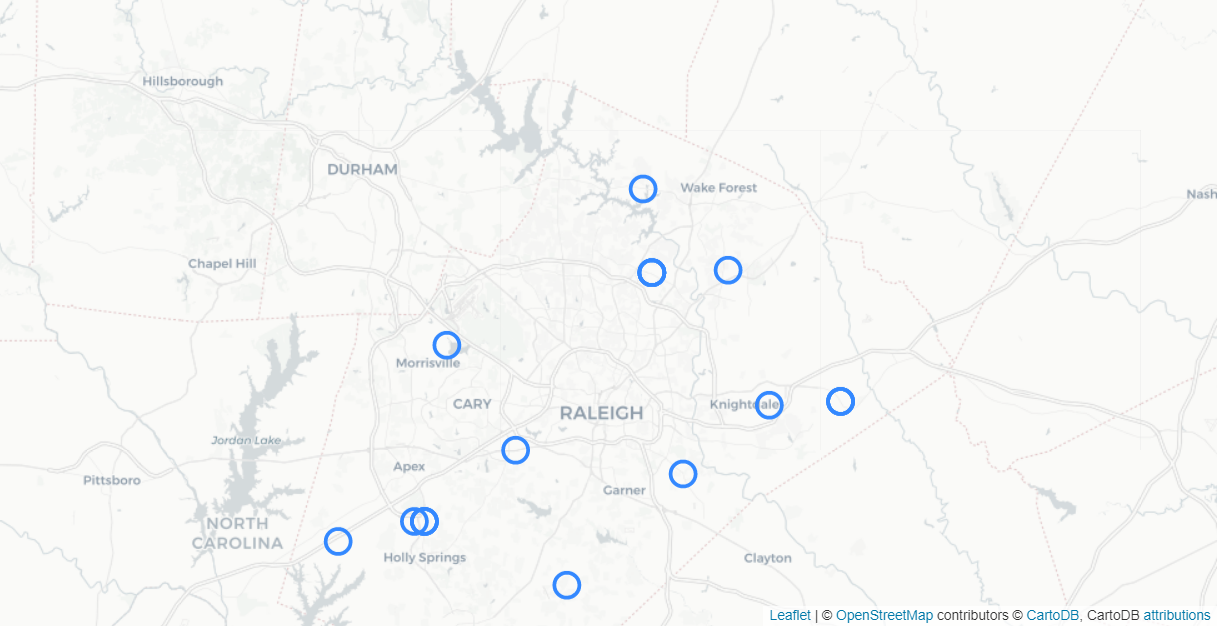

In [1]:
from IPython.display import Image
Image(filename = "GD Sites.png", width = 600, height = 300)